# Importing libraries

In [1]:
import pandas as pd
import csv
import datetime as dt
import seaborn as sns
import os


# Importing Files

In [2]:
# Import the CSV file into a DataFrame
with open('commits_by_date.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(" ") for line in stripped if line)
    with open('commits_by_date_processed.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('date', 'time', 'timezone'))
        writer.writerows(lines)
        
# Read the CSV file into a DataFrame
commits = pd.read_csv('commits_by_date_processed.csv')

commits = commits.astype({'date': 'datetime64[ns]', 'time': 'datetime64[ns]', 'timezone': 'string'}, errors='ignore')
commits['floored_hour'] =commits['time'].dt.floor('H').dt.time
commits.drop(columns=['time', 'timezone'], inplace=True)

commits = commits.groupby(['date', 'floored_hour']).size().reset_index(name='commits')
commits = commits.rename(columns={'floored_hour': 'time'}, inplace=False)
commits['date'] =  commits['date'].dt.day_name()
commits.to_csv('commits_by_date_processed.csv', index=False)
commits = commits.groupby(['date', 'time']).agg({'commits': 'mean'}).reset_index().rename(columns={'commits': 'avg_commits'})
commits['time'] = pd.to_datetime(commits['time'], format='%H:%M:%S').dt.strftime('%-I%p')  


commits
# commits.to_csv('commits_by_date_processed.csv', index=False)



/var/folders/fl/hl534wb529b4csy5lcjy6scc0000gn/T/ipykernel_46761/2095836379.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  commits = commits.astype({'date': 'datetime64[ns]', 'time': 'datetime64[ns]', 'timezone': 'string'}, errors='ignore')


,date,time,avg_commits
0,Friday,1AM,1.000000
1,Friday,2AM,1.000000
2,Friday,9AM,2.000000
3,Friday,11AM,1.000000
4,Friday,2PM,1.000000
5,Friday,3PM,1.000000
6,Friday,4PM,1.000000
7,Friday,10PM,1.000000
8,Friday,11PM,1.000000
9,Monday,8AM,1.000000


In [3]:




hour_order = [
    '12AM', '1AM', '2AM', '3AM', '4AM', '5AM',
    '6AM', '7AM', '8AM', '9AM', '10AM', '11AM',
    '12PM', '1PM', '2PM', '3PM', '4PM', '5PM',
    '6PM', '7PM', '8PM', '9PM', '10PM', '11PM'
]

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


commits['date'] = pd.Categorical(commits['date'], categories=day_order, ordered=True)
commits['time'] = pd.Categorical(commits['time'], categories=hour_order, ordered=True)


commits.to_csv('commits_by_date_processed.csv', index=False)

In [4]:
full_grid = pd.DataFrame(
    [(d, h) for d in day_order for h in hour_order],
    columns=['date', 'time']
)

full_grid

commits = full_grid.merge(commits, on=['date', 'time'], how='left').fillna(0)
commits['avg_commits'] = commits['avg_commits'].astype(float)


commits['date'] = pd.Categorical(commits['date'], categories=day_order, ordered=True)
commits['time'] = pd.Categorical(commits['time'], categories=hour_order, ordered=True)

# Optional: just to visually confirm order before pivoting
commits = commits.sort_values(['date', 'time'])
commits.to_csv('commits_by_date_processed.csv', index=False)

# Plotting data

In [5]:
commits = commits.pivot(index='date', columns='time', values='avg_commits').fillna(0).astype(float)

In [6]:
commits.where(commits > 0)


time,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,...,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
date,,,,,,,,,,,,,,,,,,,,,
Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,3.5,2.000000,2.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,2.0,1.400000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Wednesday,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,3.0,3.000000,1.5,NaN,NaN,1.0,NaN,3.0,1.0,NaN
Thursday,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,1.666667,2.0,NaN,2.0,NaN,NaN,1.0,NaN,NaN
Friday,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0
Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
Sunday,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,1.0


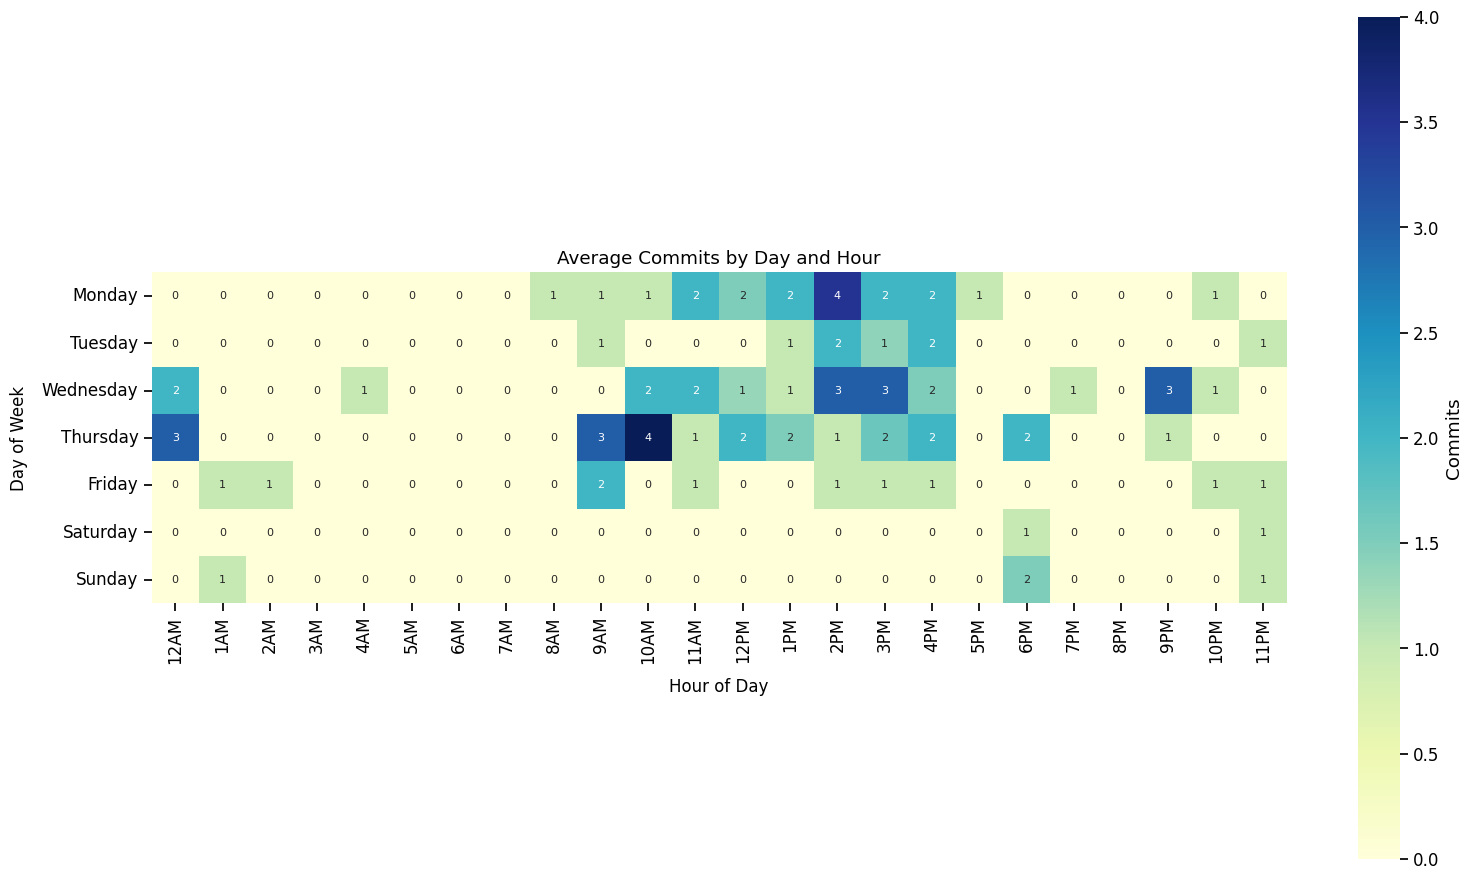

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.1)  # Options: paper, notebook, talk, poster

plt.figure(figsize=(16, 9))  # Play with width/height to get the size you like


plt.title('Average Commits by Day and Hour', fontsize=16, weight='bold', pad=20)
plt.xlabel('Hour of Day', fontsize=12, labelpad=10)
plt.ylabel('Day of Week', fontsize=12, labelpad=10)

sns.heatmap(
    commits,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='none',
    cbar=True,
    square=True,
    xticklabels=True,
    yticklabels=True,
    annot_kws={"size": 8},
    cbar_kws={'label': 'Commits'}
).set(title='Average Commits by Day and Hour', xlabel='Hour of Day', ylabel='Day of Week')



plt.tight_layout()
plt.savefig('commit_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()